In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from typing import List, Tuple


class FactorModel(nn.Module):
    def __init__(self, N: int, K: List[int], d: int):
        super(FactorModel, self).__init__()
        self.N = N  # Number of questions
        self.K = K  # List of number of categorical answers for each question
        self.d = d  # Latent dimension
        self.W = nn.ModuleList([nn.Linear(d, K[i] - 1, bias=False) for i in range(N)])
        self.biases = nn.ParameterList(
            [nn.Parameter(torch.randn(K[i] - 1)) for i in range(N)]
        )

    def forward(self, v: torch.Tensor) -> List[torch.Tensor]:
        logits = [self.W[n](v) + self.biases[n] for n in range(self.N)]
        # Append zero logits for the last category to each question's logits
        logits = [
            torch.cat((logit, torch.zeros(logit.size(0), 1).to(logit.device)), dim=1)
            for logit in logits
        ]
        return logits

    def predict_proba(self, v: torch.Tensor) -> List[torch.Tensor]:
        logits = self.forward(v)  # List of logits for each question
        probabilities = [torch.softmax(logit, dim=-1) for logit in logits]
        return probabilities


def loss_function(
    model: FactorModel,
    v: torch.Tensor,
    answers: torch.Tensor,
    lambda1: float,
    lambda2: float,
) -> torch.Tensor:

    criterion = nn.NLLLoss(reduction="sum")
    logits = model.forward(v)

    total_loss = 0
    for n in range(model.N):
        log_probs = nn.functional.log_softmax(logits[n], dim=1)
        total_loss += criterion(log_probs, answers[:, n])
    nll_loss = total_loss.clone()
    # L2 Regularization
    l2_reg = sum(torch.norm(W.weight, 2) ** 2 for W in model.W)
    total_loss += lambda1 * l2_reg
    total_loss += lambda2 * torch.norm(v, 2) ** 2
    return total_loss, nll_loss


def train_model(
    model: FactorModel,
    answers: torch.Tensor,
    epochs: int = 1000,
    lr: float = 0.01,
    lambda1: float = 0.01,
    lambda2: float = 0.01,
) -> Tuple[FactorModel, torch.Tensor]:

    v = torch.randn(len(answers), model.d, requires_grad=True)
    print(v[0], v[100])
    # optimizer = optim.Adam(model.parameters(), lr=lr)
    optimizer = optim.Adam(list(model.parameters()) + [v], lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        loss, nllloss = loss_function(model, v, answers, lambda1, lambda2)
        loss.backward()
        optimizer.step()
        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item()}, nll_loss: {nllloss.item()}")
    return model, v

In [2]:
import json

N = 22  # number of questions
M = 100  # number of articles

with open("../CA/Alignment_zho_Territorial_disputes_in_the_South_China_Sea.json") as f:
    data_zho = json.load(f)

# Initialize a list to store the extracted values
llm_zho = []

# Iterate through the JSON objects to extract `post_LLM_answer`
for item in data_zho:
    if "QnA" in item:
        for qna in item["QnA"]:
            if "post_LLM_answer" in qna:
                llm_zho.append(qna["post_LLM_answer"])

# reshape the list to a MxN matrix
llm_zho = np.array(llm_zho).reshape(-1, 1)
llm_zho = np.array(llm_zho).reshape(M, N)

# replace A with  number 0, B with 1, C with 2, D with 3
llm_zho = np.where(llm_zho == "A", 0, llm_zho)
llm_zho = np.where(llm_zho == "B", 1, llm_zho)
llm_zho = np.where(llm_zho == "C", 2, llm_zho)
llm_zho = np.where(llm_zho == "D", 3, llm_zho)
llm_zho = np.where(llm_zho == "E", 4, llm_zho)
llm_zho = llm_zho.astype(int)
# convert llm_zho to numpy array
llm_zho = np.array(llm_zho)

In [3]:
import json

N = 22  # number of questions
M = 100  # number of articles

with open("../CA/Alignment_eng_Territorial_disputes_in_the_South_China_Sea.json") as f:
    data_eng = json.load(f)

# Initialize a list to store the extracted values
llm_eng = []

# Iterate through the JSON objects to extract `post_LLM_answer`
for item in data_eng:
    if "QnA" in item:
        for qna in item["QnA"]:
            if "post_LLM_answer" in qna:
                llm_eng.append(qna["post_LLM_answer"])

# reshape the list to a MxN matrix
llm_eng = np.array(llm_eng).reshape(-1, 1)
llm_eng = np.array(llm_eng).reshape(M, N)

# replace A with  number 0, B with 1, C with 2, D with 3
llm_eng = np.where(llm_eng == "A", 0, llm_eng)
llm_eng = np.where(llm_eng == "B", 1, llm_eng)
llm_eng = np.where(llm_eng == "C", 2, llm_eng)
llm_eng = np.where(llm_eng == "D", 3, llm_eng)
llm_eng = np.where(llm_eng == "E", 4, llm_eng)
llm_eng = llm_eng.astype(int)
# convert llm_zho to numpy array
llm_eng = np.array(llm_eng)

In [4]:
N = 21  # Number of questions
d = 3  # Latent dimension
# list of number of categorical answers for each question
K = [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 5]

model = FactorModel(N, K, d)

# Prepare Data
M = 200  # Number of articles
# merge the two languages
data = np.concatenate((llm_eng, llm_zho), axis=0)

data = data[:M, :N]
# convert data to torch tensor long
answers = torch.tensor(data, dtype=torch.long)

In [5]:
llm_eng

array([[0, 1, 0, ..., 1, 0, 1],
       [1, 1, 0, ..., 0, 2, 0],
       [0, 1, 0, ..., 1, 3, 0],
       ...,
       [0, 1, 0, ..., 0, 4, 4],
       [0, 1, 0, ..., 0, 4, 4],
       [0, 1, 0, ..., 1, 0, 1]])

In [6]:
llm_zho

array([[0, 1, 0, ..., 1, 1, 2],
       [0, 1, 0, ..., 1, 0, 1],
       [0, 1, 0, ..., 1, 0, 1],
       ...,
       [0, 1, 0, ..., 1, 1, 2],
       [0, 0, 0, ..., 1, 1, 4],
       [0, 0, 0, ..., 0, 2, 4]])

In [7]:
data.min(), data.max(), data.mean(axis=0)

(0,
 4,
 array([0.03 , 0.775, 0.045, 0.765, 0.99 , 0.67 , 0.705, 0.415, 0.635,
        0.99 , 0.985, 0.875, 0.925, 0.105, 0.195, 0.59 , 0.815, 0.755,
        0.485, 0.825, 1.2  ]))

In [8]:
data[-1]

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 2])

In [9]:
answers

tensor([[0, 1, 0,  ..., 1, 1, 0],
        [1, 1, 0,  ..., 0, 0, 2],
        [0, 1, 0,  ..., 0, 1, 3],
        ...,
        [0, 1, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 1, 1],
        [0, 0, 0,  ..., 0, 0, 2]])

In [10]:
epo = 20000
trained_model, v = train_model(
    model, answers, epochs=epo, lr=0.01, lambda1=0.01, lambda2=0.01
)

tensor([-0.4861, -0.6792, -0.7130], grad_fn=<SelectBackward0>) tensor([ 0.8211, -0.5149, -0.3703], grad_fn=<SelectBackward0>)


/Users/minlingzhou/miniconda3/envs/my-env/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


Epoch 0, Loss: 3915.250732421875, nll_loss: 3909.489990234375
Epoch 100, Loss: 1864.47509765625, nll_loss: 1855.907958984375
Epoch 200, Loss: 1225.1221923828125, nll_loss: 1212.740478515625
Epoch 300, Loss: 947.305908203125, nll_loss: 931.7540283203125
Epoch 400, Loss: 850.6834716796875, nll_loss: 832.9401245117188
Epoch 500, Loss: 795.5242309570312, nll_loss: 775.7445068359375
Epoch 600, Loss: 758.0650024414062, nll_loss: 736.3928833007812
Epoch 700, Loss: 731.1710205078125, nll_loss: 707.7453002929688
Epoch 800, Loss: 711.201904296875, nll_loss: 686.1302490234375
Epoch 900, Loss: 695.6327514648438, nll_loss: 669.0335693359375
Epoch 1000, Loss: 682.8558349609375, nll_loss: 654.850341796875
Epoch 1100, Loss: 672.1996459960938, nll_loss: 642.9091796875
Epoch 1200, Loss: 663.3527221679688, nll_loss: 632.8889770507812
Epoch 1300, Loss: 655.9659423828125, nll_loss: 624.4234619140625
Epoch 1400, Loss: 649.7257690429688, nll_loss: 617.1890869140625
Epoch 1500, Loss: 644.3878173828125, nll_lo

In [11]:
print(trained_model.W[0].weight)

Parameter containing:
tensor([[1.0757, 2.1662, 2.9414]], requires_grad=True)


In [12]:
v[0], v[100], v[1], v[101]

(tensor([-2.2421, -1.5351,  0.2089], grad_fn=<SelectBackward0>),
 tensor([ 0.6003, -0.4359, -1.4139], grad_fn=<SelectBackward0>),
 tensor([ 0.9977,  0.2640, -4.3493], grad_fn=<SelectBackward0>),
 tensor([-0.0843, -2.1639,  1.7113], grad_fn=<SelectBackward0>))

In [13]:
trained_model.predict_proba(v[0].unsqueeze(0)), answers[0]

([tensor([[0.9974, 0.0026]], grad_fn=<SoftmaxBackward0>),
  tensor([[0.0476, 0.9524]], grad_fn=<SoftmaxBackward0>),
  tensor([[1.0000e+00, 1.4597e-23]], grad_fn=<SoftmaxBackward0>),
  tensor([[0.4653, 0.5347]], grad_fn=<SoftmaxBackward0>),
  tensor([[1.5336e-06, 1.0000e+00]], grad_fn=<SoftmaxBackward0>),
  tensor([[0.6006, 0.3994]], grad_fn=<SoftmaxBackward0>),
  tensor([[0.9190, 0.0810]], grad_fn=<SoftmaxBackward0>),
  tensor([[1.0000e+00, 1.0960e-19]], grad_fn=<SoftmaxBackward0>),
  tensor([[0.3686, 0.6314]], grad_fn=<SoftmaxBackward0>),
  tensor([[0.0105, 0.9895]], grad_fn=<SoftmaxBackward0>),
  tensor([[0.0152, 0.9848]], grad_fn=<SoftmaxBackward0>),
  tensor([[0.0471, 0.9529]], grad_fn=<SoftmaxBackward0>),
  tensor([[5.3958e-17, 1.0000e+00]], grad_fn=<SoftmaxBackward0>),
  tensor([[1.0000e+00, 2.6287e-17]], grad_fn=<SoftmaxBackward0>),
  tensor([[1.0000e+00, 1.3123e-07]], grad_fn=<SoftmaxBackward0>),
  tensor([[0.6287, 0.3713]], grad_fn=<SoftmaxBackward0>),
  tensor([[0.0013, 0.998

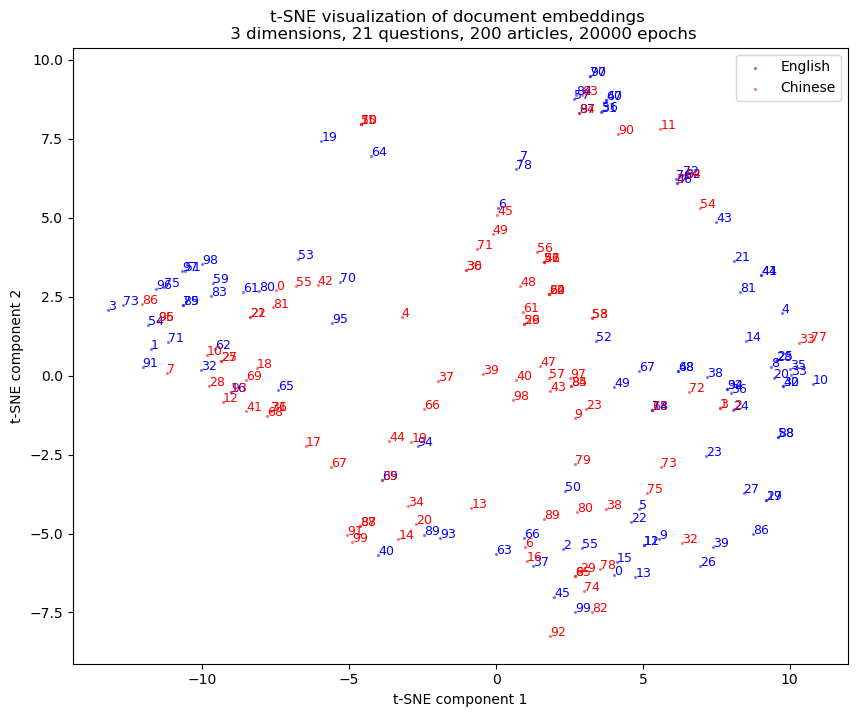

In [14]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler


# Extract the latent vectors v
latent_vectors = v.detach().numpy()

# Normalize the latent vectors
# scaler = StandardScaler()
# latent_vectors_normalized = scaler.fit_transform(latent_vectors)

# Apply t-SNE to reduce dimensionality to 2D
tsne = TSNE(n_components=2, random_state=42)
# v_2d = tsne.fit_transform(latent_vectors)
v_2d = tsne.fit_transform(latent_vectors)

# Plot the 2D embeddings with the inedx of each point
plt.figure(figsize=(10, 8))
# split the two languages
v_2d_eng = v_2d[:100]
v_2d_zho = v_2d[100:]
for index, (x, y) in enumerate(v_2d_eng):
    plt.scatter(
        x, y, alpha=0.4, color="blue", s=2, label="English" if index == 0 else ""
    )
    plt.text(x, y, str(index), fontsize=9, color="blue")

for index, (x, y) in enumerate(v_2d_zho):
    plt.scatter(
        x, y, alpha=0.4, color="red", s=2, label="Chinese" if index == 0 else ""
    )
    plt.text(x, y, str(index), fontsize=9, color="red")
plt.title(
    f"t-SNE visualization of document embeddings \n {d} dimensions, {N} questions, {M} articles, {epo} epochs"
)

plt.xlabel("t-SNE component 1")
plt.ylabel("t-SNE component 2")
plt.legend()
plt.show()

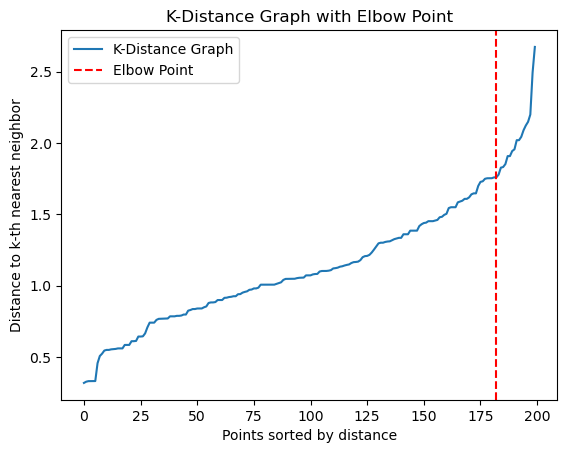

Elbow point (knee) is at index: 182, distance: 1.7598090370329493


In [15]:
from sklearn.neighbors import NearestNeighbors
from kneed import KneeLocator

# Compute k-nearest neighbors (k is set to min_samples)
min_samples = 5
neigh = NearestNeighbors(n_neighbors=min_samples)
nbrs = neigh.fit(v_2d)
distances, indices = nbrs.kneighbors(v_2d)

# Sort distances to the k-th nearest neighbor
distances = np.sort(distances[:, min_samples - 1])

x = np.arange(len(distances))
kneedle = KneeLocator(x, distances, curve="convex", direction="increasing")

# Plot the results
plt.plot(x, distances, label="K-Distance Graph")
plt.axvline(x=kneedle.knee, color="r", linestyle="--", label="Elbow Point")
plt.xlabel("Points sorted by distance")
plt.ylabel("Distance to k-th nearest neighbor")
plt.title("K-Distance Graph with Elbow Point")
plt.legend()
plt.show()

# Print the knee point
print(
    f"Elbow point (knee) is at index: {kneedle.knee}, distance: {distances[kneedle.knee]}"
)

In [16]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=distances[kneedle.knee], min_samples=min_samples)
labels = dbscan.fit_predict(v_2d)

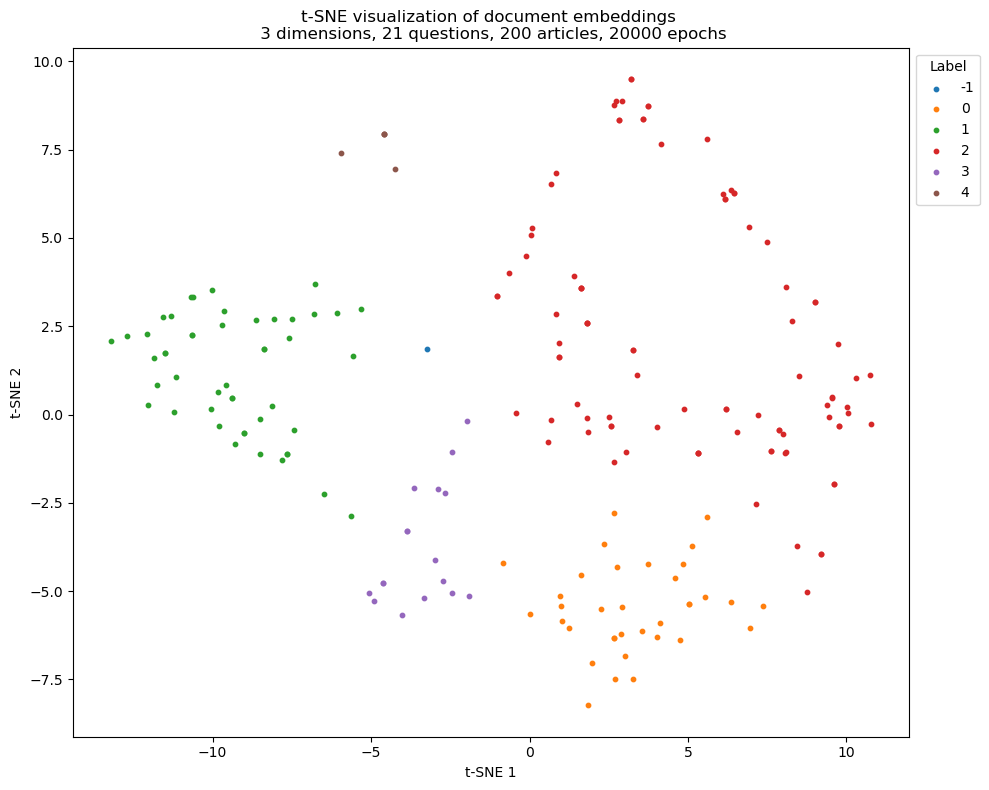

In [17]:
plt.figure(figsize=(10, 8))
for y in np.unique(labels):
    plt.scatter(
        v_2d[labels == y, 0], v_2d[labels == y, 1], label=f"{y}", s=10, marker="o"
    )

plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.title(
    f"t-SNE visualization of document embeddings \n {d} dimensions, {N} questions, {M} articles, {epo} epochs"
)
plt.legend(title="Label", loc="upper left", bbox_to_anchor=(1, 1), ncol=1)
plt.tight_layout()
plt.show()

In [18]:
# get the index of cluster -1
cluster_1 = np.where(labels == labels.max())
# convert the tuple to list
cluster_1 = list(cluster_1[0])

with open("../CA/combined_Territorial_disputes_in_the_South_China_Sea.json") as f:
    data = json.load(f)
for i in cluster_1:
    print(data[i]["title"])

Qualcomm Deepens Taiwan Ties with Kaohsiung Innovation Center for NASDAQ:QCOM by signalmastermind
Britain's MI6 recruited Chinese government employees as spies, China said. - ExBulletin
早读｜2024年高考十问十答来了；广东荔枝接续上市，价格有所回落
山东省农村信用社联合社原党委副书记、纪委书记展西亮接受纪律审查和监察调查
【翻墙必看】大陆普通人生活遭围剿 - 大纪元


In [19]:
# get the index of cluster -1
cluster_1 = np.where(labels == labels.min())
# convert the tuple to list
cluster_1 = list(cluster_1[0])

with open("../CA/combined_Territorial_disputes_in_the_South_China_Sea.json") as f:
    data = json.load(f)
for i in cluster_1:
    print(data[i]["title"])

中国驻韩大使馆称"韩国对台湾和南中国海问题说三道四"


In [20]:
# get the index of cluster -1
cluster_1 = np.where(labels == 0)
# convert the tuple to list
cluster_1 = list(cluster_1[0])

with open("../CA/combined_Territorial_disputes_in_the_South_China_Sea.json") as f:
    data = json.load(f)
for i in cluster_1:
    print(data[i]["title"])

World News | Philippines Says China Coast Guard Seized Food Dropped by Plane for Filipino Forces in Disputed Sea | LatestLY
Phl, U.S., Japan coast guards vow to keep SCS safe, free
Philippines denies its troops pointed guns at Chinese coast guard personnel
Philippines says China coast guard seized food dropped by plane for Filipino forces in disputed sea
Philippines says China coast guard seized food dropped by plane for Filipino forces in disputed sea
Philippines says China coast guard seized food dropped by plane for...
Philippines says China coast guard seized food dropped by plane for Filipino forces in disputed sea
Philippines says China coast guard seized food dropped by plane for Filipino forces in disputed sea
Philippines denies soldiers pointed guns at China coast guard
PH Navy slams Chinese military activities in Sabina Shoal
Analysis: China and Trump loomed large at Singaporean defense summit
Philippines: Troops acted professionally in South China Sea
Defending Japan and the

In [21]:
# get the index of cluster -1
cluster_1 = np.where(labels == 1)
# convert the tuple to list
cluster_1 = list(cluster_1[0])

with open("../CA/combined_Territorial_disputes_in_the_South_China_Sea.json") as f:
    data = json.load(f)
for i in cluster_1:
    print(data[i]["title"])

Turkey's Top Diplomat Visits China, Planning Stops in Uyghur Genocide Region
Resetting the clock: Hun Sen urges US to restart dialogue and military cooperation - Khmer Times
US Defense Secretary Lloyd Austin Confirms Restoration of US-Cambodia Ties, Joint Military Drills | CamboJA News
Ukrainian president berates China at Singapore security conference
"Geopolitical Risk Is Everywhere"
'The King's Speech'
Indefatigable
China cites 'dishonorable role' of US in sea dispute after Marcos censure - BusinessWorld Online
Facing up to China's Hybrid Warfare in the Pacific
China says US plays 'dishonorable role' supporting Philippines in South China Sea
Chinese defense minister denounces 'outside forces' at security forum
Cui Tiankai: External forces hyping up territorial disputes in South China Sea
Despite South China Sea row with China, Philippines eyes 'robust, stable' trade
World News | Finance and Equity Should Be the Core of COP29 Talks | LatestLY
Finance and equity should be the core of C

## Verify v that have same answers

In [22]:
v[101:104], v[24], v[34], v[36], v[92]

(tensor([[-0.0843, -2.1639,  1.7113],
         [-0.0843, -2.1639,  1.7113],
         [-0.0843, -2.1639,  1.7113]], grad_fn=<SliceBackward0>),
 tensor([-0.0843, -2.1639,  1.7113], grad_fn=<SelectBackward0>),
 tensor([-0.0843, -2.1639,  1.7113], grad_fn=<SelectBackward0>),
 tensor([-0.0843, -2.1639,  1.7113], grad_fn=<SelectBackward0>),
 tensor([-0.0843, -2.1639,  1.7113], grad_fn=<SelectBackward0>))

In [30]:
# save the v_2d to a csv file
import pandas as pd

v_2d_df = pd.DataFrame(v_2d, columns=["x", "y"])
v_2d_df.to_csv("v_2d.csv", index=False)

In [31]:
v_2d_df

,x,y
0,4.025120,-6.302742
1,-11.752931,0.829917
2,2.266053,-5.494023
3,-13.203978,2.072242
4,9.718925,1.992752
...,...,...
195,-11.508296,1.738215
196,-11.508298,1.738217
197,2.509815,-0.061110
198,0.573530,-0.772236


In [3]:
import plotly.express as px
import pandas as pd
from sklearn.decomposition import PCA
import json

v_2d_df = pd.read_csv(
    "v_2d.csv",
)

v_2d_df["language"] = ["English"] * 100 + ["Chinese"] * 100

# read the summary from json file
with open(
    "../CA/summary_combined_Territorial_disputes_in_the_South_China_Sea.json"
) as f:
    data = json.load(f)
summary = []
for item in data:
    summary.append(item["summary"])

v_2d_df["summary"] = summary


# Function to format summaries for hover text
def format_summary(text):
    return text.replace("\n", "<br>")


v_2d_df["formatted_summary"] = v_2d_df["summary"].apply(format_summary)

# Plot using Plotly
fig = px.scatter(
    v_2d_df,
    x="x",
    y="y",
    color="language",
    title="t-SNE Visualization of News Articles",
    labels={"x": "t-SNE component 1", "y": "t-SNE component 2"},
    hover_data={"summary": False, "language": False, "x": False, "y": False},
    symbol="language",
)

# Customize the hover template
fig.update_traces(
    hovertemplate="<b>Summary:</b><br>%{customdata[0]}<extra></extra>",
    customdata=v_2d_df[["formatted_summary"]].values,
)
# Plot using Plotly
# plot the first 100 articles using cross and the last 100 articles using circle
"""
fig = px.scatter(
    v_2d_df,
    x="x",
    y="y",
    color="language",
    title="t-SNE Visualization of News Articles",
    labels={"x": "t-SNE component 1", "y": "t-SNE component 2"},
    hover_data={"summary": True, "language": False, "x": False, "y": False},
    symbol="language",
)
"""

fig.show()
# Save the plot as an HTML file
fig.write_html("interactive_plot.html")